# Pre-trained models and transfer learning

Training CNNs can take a lot of time, and a lot of data is required for that task. However, much of the time is spent to learn the best low-level filters that a network is using to extract patterns from images. A natural question arises - can we use a neural network trained on one dataset and adapt it to classifying different images without full training process?

This approach is called **transfer learning**, because we transfer some knowledge from one neural network model to another. In transfer learning, we typically start with a pre-trained model, which has been trained on some large image dataset, such as **ImageNet**. Those models can already do a good job extracting different features from generic images, and in many cases just building a classifier on top of those extracted features can yield a good result.

训练 CNN 可能会花费大量时间，而且该任务需要大量数据。 然而，大部分时间都花在了学习网络用于从图像中提取模式的最佳低级过滤器上。 一个自然的问题出现了——我们是否可以使用在一个数据集上训练的神经网络，并在没有完整训练过程的情况下使其适应不同图像的分类？

这种方法称为**迁移学习**，因为我们将一些知识从一个神经网络模型迁移到另一个。 在迁移学习中，我们通常从一个预训练模型开始，该模型已经在一些大型图像数据集上进行了训练，例如 **ImageNet**。 这些模型已经可以很好地从通用图像中提取不同的特征，并且在许多情况下，只需在这些提取的特征之上构建分类器就可以产生良好的结果。

In [14]:
!wget https://raw.githubusercontent.com/MicrosoftDocs/pytorchfundamentals/main/computer-vision-pytorch/pytorchcv.py

--2023-02-09 13:07:16--  https://raw.githubusercontent.com/MicrosoftDocs/pytorchfundamentals/main/computer-vision-pytorch/pytorchcv.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6540 (6.4K) [text/plain]
Saving to: ‘pytorchcv.py.3’

pytorchcv.py.3      100%[===================>]   6.39K  --.-KB/s    in 0s      

2023-02-09 13:07:16 (107 MB/s) - ‘pytorchcv.py.3’ saved [6540/6540]



In [15]:
!pip install -r https://raw.githubusercontent.com/MicrosoftDocs/pytorchfundamentals/main/computer-vision-pytorch/requirements.txt

In [16]:
!pip install torchinfo

In [17]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchinfo import summary
import numpy as np
import os

from pytorchcv import train, plot_results, display_dataset, train_long, check_image_dir

## Cats vs. Dogs Dataset

In this unit, we will solve a real-life problem of classifying images of cats and dogs. For this reason, we will use [Kaggle Cats vs. Dogs Dataset](https://www.kaggle.com/c/dogs-vs-cats), which can also be downloaded [from Microsoft](https://www.microsoft.com/en-us/download/details.aspx?id=54765).

Let's download this dataset and extract it into `data` directory (this process may take some time!):


在本单元中，我们将解决一个现实生活中的猫狗图像分类问题。 为此，我们将使用 [Kaggle Cats vs. Dogs Dataset](https://www.kaggle.com/c/dogs-vs-cats)，也可以 [从 Microsoft](https://www .microsoft.com/zh-cn/download/details.aspx?id=54765)

让我们下载这个数据集并将其解压到`data`目录中（这个过程可能需要一些时间！）：

In [18]:
if not os.path.exists('data/kagglecatsanddogs_5340.zip'):
    !wget -P data -q https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

In [19]:
import zipfile
if not os.path.exists('data/PetImages'):
    with zipfile.ZipFile('data/kagglecatsanddogs_5340.zip', 'r') as zip_ref:
        zip_ref.extractall('data')

Unfortunately, there are some corrupt image files in the dataset. We need to do quick cleaning to check for corrupted files. In order not to clobber this tutorial, we moved the code to verify dataset into a module, and we will just call it here. `check_image_dir` goes over the whole dataset image by image, tries to load the image and check if it can be loaded correctly. All corrupt images are deleted.

不幸的是，数据集中有一些损坏的图像文件。 我们需要进行快速清理以检查损坏的文件。 为了不破坏本教程，我们将验证数据集的代码移到了一个模块中，我们将在这里调用它。 `check_image_dir` 逐张检查整个数据集，尝试加载图像并检查是否可以正确加载。 所有损坏的图像都被删除。

In [20]:
check_image_dir('data/PetImages/Cat/*.jpg')
check_image_dir('data/PetImages/Dog/*.jpg')

Corrupt image: data/PetImages/Cat/666.jpg
Corrupt image: data/PetImages/Dog/11702.jpg


/anaconda/envs/azureml_py38_PT_and_TF/lib/python3.8/site-packages/PIL/TiffImagePlugin.py:845: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Next, let's load the images into PyTorch dataset, converting them to tensors and doing some normalization. We define image transformation pipeline by composing several primitive transformations using `Compose`:
* `Resize` resizes our image to 256x256 dimensions
* `CenterCrop` gets the central part of the image with size 224x224. Pre-trained VGG network has been trained on 224x224 images, thus we need to bring our dataset to this size.
* `ToTensor` normalizes pixel intensities to be in 0..1 range, and convert images to PyTorch tensors
* `std_normalize` transform is additional normalization step specific for VGG network. When training a VGG network, original images from ImageNet were transformed by subtracting dataset mean intensity by color and dividing by standard deviation (also by color). Thus, we need to apply the same transformation to our dataset, so that all images are processed correctly. 

There are a few reason why we resized images to size 256, and then cropped to 224 pixels:
* We wanted to demonstrate more possible transformations.
* Pets are usually somewhere in the central part of the image, so we can improve classification by focusing more on the central part
* Since some of the images are not square, we end up having padded parts of the image that do not contain any useful picture data, and cropping the image a bit reduces the padded part.

接下来，让我们将图像加载到 PyTorch 数据集中，将它们转换为张量并进行一些归一化。 我们通过使用 `Compose` 组合几个原始转换来定义图像转换管道：
* `Resize` 将我们的图像调整为 256x256 尺寸
* `CenterCrop` 获取图像的中心部分，尺寸为 224x224。 预训练的 VGG 网络已经在 224x224 图像上进行了训练，因此我们需要将我们的数据集调整到这个大小。
* `ToTensor` 将像素强度标准化为在 0..1 范围内，并将图像转换为 PyTorch 张量
* `std_normalize` 转换是特定于 VGG 网络的附加规范化步骤。 在训练 VGG 网络时，ImageNet 的原始图像通过按颜色减去数据集平均强度并除以标准差（也按颜色）进行转换。 因此，我们需要对数据集应用相同的转换，以便正确处理所有图像。

我们将图像大小调整为 256，然后裁剪为 224 像素的原因有几个：
* 我们想展示更多可能的转换。
* 宠物通常位于图像的中心部分，因此我们可以通过更多地关注中心部分来改进分类
* 由于一些图像不是正方形的，我们最终填充了不包含任何有用图片数据的图像部分，并且稍微裁剪图像减少了填充部分。

In [ ]:
std_normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])

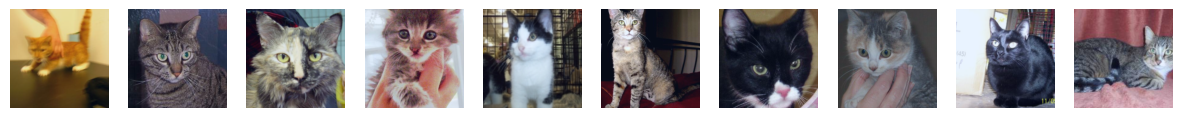

In [21]:
std_normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])
trans = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(), 
        std_normalize])
dataset = torchvision.datasets.ImageFolder('data/PetImages',transform=trans)
trainset, testset = torch.utils.data.random_split(dataset,[20000,len(dataset)-20000])

display_dataset(dataset)

## Pre-trained models

There are many different pre-trained models available inside `torchvision` module, and even more models can be found on the Internet. Let's see how simplest VGG-16 model can be loaded and used:


`torchvision` 模块中有许多不同的预训练模型，甚至可以在 Internet 上找到更多模型。 让我们看看如何加载和使用最简单的 VGG-16 模型：

In [22]:
# Download model weights in the sandbox environment
!mkdir -p ~/.torch/models
!wget -P ~/.torch/models -q https://download.pytorch.org/models/vgg16-397923af.pth

In [23]:
vgg = torchvision.models.vgg16(
      weights=torchvision.models.VGG16_Weights.DEFAULT)
sample_image = dataset[0][0].unsqueeze(0)
res = vgg(sample_image)
print(res[0].argmax())

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /home/mslearnuser/.cache/torch/hub/checkpoints/vgg16-397923af.pth


URLError: <urlopen error [Errno 101] Network is unreachable>

The result that we have received is a number of an `ImageNet` class, which can be looked up [here](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). We can use the following code to automatically load this class table and return the result:

我们收到的结果是一些 `ImageNet` 类，可以在 [此处](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a) 中查找。 我们可以使用下面的代码来自动加载这个类表并返回结果：

In [ ]:
import json, requests
class_map = json.loads(requests.get("https://raw.githubusercontent.com/MicrosoftDocs/pytorchfundamentals/main/computer-vision-pytorch/imagenet_class_index.json").text)
class_map = { int(k) : v for k,v in class_map.items() }

class_map[res[0].argmax().item()]

Let's also see the architecture of the VGG-16 network:

我们也来看看 VGG-16 网络的架构：

In [ ]:
summary(vgg,input_size=(1,3,224,224))

In addition to the layer we already know, there is also another layer type called **Dropout**. These layers act as **regularization** technique. Regularization makes slight modifications to the learning algorithm so the model generalizes better. During training, dropout layers discard some proportion (around 30%) of the neurons in the previous layer, and training happens without them. This helps to get the optimization process out of local minima, and to distribute decisive power between different neural paths, which improves overall stability of the network.

除了我们已经知道的层之外，还有一种层类型叫做 **Dropout**。 这些层充当**正则化**技术。 正则化对学习算法进行了细微的修改，因此模型可以更好地泛化。 在训练过程中，dropout 层会丢弃前一层中一定比例（约 30%）的神经元，并且在没有它们的情况下进行训练。 这有助于使优化过程脱离局部极小值，并在不同的神经路径之间分配决定权，从而提高网络的整体稳定性。

## GPU computations

Deep neural networks, such as VGG-16 and other more modern architectures require quite a lot of computational power to run. It makes sense to use GPU acceleration, if it is available. In order to do so, we need to explicitly move all tensors involved in the computation to GPU.

The way it is normally done is to check the availability of GPU in the code, and define `device` variable that points to the computational device - either GPU or CPU.

深度神经网络，例如 VGG-16 和其他更现代的架构，需要相当多的计算能力才能运行。 如果可用，使用 GPU 加速是有意义的。 为此，我们需要将计算中涉及的所有张量显式移动到 GPU。

通常的做法是检查代码中 GPU 的可用性，并定义指向计算设备的“设备”变量——GPU 或 CPU。


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print('Doing computations on device = {}'.format(device))

vgg.to(device)
sample_image = sample_image.to(device)

vgg(sample_image).argmax()


## Extracting VGG features

If we want to use VGG-16 to extract features from our images, we need the model without final classification layers. In fact, this "feature extractor" can be obtained using `vgg.features` method:

如果我们想使用 VGG-16 从我们的图像中提取特征，我们需要没有最终分类层的模型。 事实上，这个“特征提取器”可以使用 `vgg.features` 方法获得：

In [ ]:
res = vgg.features(sample_image).cpu()
plt.figure(figsize=(15,3))
plt.imshow(res.detach().view(-1,512))
print(res.size())

The dimension of feature tensor is 512x7x7, but in order to visualize it we had to reshape it to 2D form.

Now let's try to see if those features can be used to classify images. Let's manually take some portion of images (800 in our case), and pre-compute their feature vectors. We will store the result in one big tensor called `feature_tensor`, and also labels into `label_tensor`:

特征张量的维度是 512x7x7，但为了将其可视化，我们必须将其重塑为二维形式。

现在让我们尝试看看这些特征是否可用于对图像进行分类。 让我们手动获取部分图像（在我们的例子中为 800），并预先计算它们的特征向量。 我们会将结果存储在一个名为`feature_tensor`的大张量中，并将标签存储到`label_tensor`中：

In [ ]:
bs = 8
dl = torch.utils.data.DataLoader(dataset,batch_size=bs,shuffle=True)
num = bs*100
feature_tensor = torch.zeros(num,512*7*7).to(device)
label_tensor = torch.zeros(num).to(device)
i = 0
for x,l in dl:
    with torch.no_grad():
        f = vgg.features(x.to(device))
        feature_tensor[i:i+bs] = f.view(bs,-1)
        label_tensor[i:i+bs] = l
        i+=bs
        print('.',end='')
        if i>=num:
            break


Now we can define `vgg_dataset` that takes data from this tensor, split it into training and test sets using `random_split` function, and train a small one-layer dense classifier network on top of extracted features:

现在我们可以定义从这个张量中获取数据的 `vgg_dataset`，使用 `random_split` 函数将其分成训练集和测试集，并在提取的特征之上训练一个小型的单层密集分类器网络：

In [ ]:
vgg_dataset = torch.utils.data.TensorDataset(feature_tensor,label_tensor.to(torch.long))
train_ds, test_ds = torch.utils.data.random_split(vgg_dataset,[700,100])

train_loader = torch.utils.data.DataLoader(train_ds,batch_size=32)
test_loader = torch.utils.data.DataLoader(test_ds,batch_size=32)

net = torch.nn.Sequential(torch.nn.Linear(512*7*7,2),torch.nn.LogSoftmax()).to(device)

history = train(net,train_loader,test_loader)

The result is great, we can distinguish between a cat and a dog with almost 98% probability! However, we have only tested this approach on a small subset of all images, because manual feature extraction seems to take a lot of time.

结果很棒，我们几乎可以 98% 的概率区分猫和狗！ 然而，我们只在所有图像的一小部分上测试了这种方法，因为手动特征提取似乎需要很多时间。

## Transfer learning using one VGG network

We can also avoid manually pre-computing the features by using the original VGG-16 network as a whole during training. Let's look at the VGG-16 object structure:

我们还可以在训练过程中通过使用原始的 VGG-16 网络作为一个整体来避免手动预计算特征。 让我们看一下 VGG-16 对象结构：

In [ ]:
print(vgg)

You can see that the network contains:
* feature extractor (`features`), comprised of a number of convolutional and pooling layers
* average pooling layer (`avgpool`)
* final `classifier`, consisting of several dense layers, which turns 25088 input features into 1000 classes (which is the number of classes in ImageNet)

To train the end-to-end model that will classify our dataset, we need to:
* **replace the final classifier** with the one that will produce required number of classes. In our case, we can use one `Linear` layer with 25088 inputs and 2 output neurons.
* **freeze weights of convolutional feature extractor**, so that they are not trained. It is recommended to initially do this freezing, because otherwise untrained classifier layer can destroy the original pre-trained weights of convolutional extractor. Freezing weights can be accomplished by setting `requires_grad` property of all parameters to `False`

可以看到网络包含：
* 特征提取器（`features`），由许多卷积层和池化层组成
*平均池化层（`avgpool`）
* final `classifier`，由几个密集层组成，将 25088 个输入特征变成 1000 个类（这是 ImageNet 中的类数）

要训练对我们的数据集进行分类的端到端模型，我们需要：
* **将最终分类器**替换为将产生所需数量的类的分类器。 在我们的例子中，我们可以使用一个具有 25088 个输入和 2 个输出神经元的“线性”层。
* **冻结卷积特征提取器的权重**，这样它们就不会被训练。 建议最初进行此冻结，否则未经训练的分类器层可能会破坏卷积提取器的原始预训练权重。 可以通过将所有参数的“requires_grad”属性设置为“False”来实现冻结权重

In [ ]:
vgg.classifier = torch.nn.Linear(25088,2).to(device)

for x in vgg.features.parameters():
    x.requires_grad = False

summary(vgg,(1, 3,244,244))

As you can see from the summary, this model contain around 15 million total parameters, but only 50k of them are trainable - those are the weights of classification layer. That is good, because we are able to fine-tune smaller number of parameters with smaller number of examples.

Now let's train the model using our original dataset. This process will take a long time, so we will use the `train_long` function that will print some intermediate results without waiting for the end of epoch. It is highly recommended to run this training on GPU-enabled compute!

> **Note:** If you are interested in the implementation of the `train_long` function, refer to the `pytorchcv.py` file.

从摘要中可以看出，该模型总共包含大约 1500 万个参数，但其中只有 50k 是可训练的——这些是分类层的权重。 这很好，因为我们能够使用较少数量的示例微调较少数量的参数。

现在让我们使用原始数据集训练模型。 这个过程会花费很长时间，所以我们将使用 `train_long` 函数来打印一些中间结果，而无需等待 epoch 结束。 强烈建议在支持 GPU 的计算上运行此训练！

> **注意：** 如果您对 `train_long` 函数的实现感兴趣，请参考 `pytorchcv.py` 文件。

In [ ]:
trainset, testset = torch.utils.data.random_split(dataset,[20000,len(dataset)-20000])
train_loader = torch.utils.data.DataLoader(trainset,batch_size=16)
test_loader = torch.utils.data.DataLoader(testset,batch_size=16)

train_long(vgg,train_loader,test_loader,loss_fn=torch.nn.CrossEntropyLoss(),epochs=1,print_freq=90)

It looks like we have obtained reasonably accurate cats vs. dogs classifier! Let's save it for future use!

看起来我们已经获得了相当准确的猫狗分类器！ 让我们保存它以备将来使用！

In [ ]:
torch.save(vgg,'data/cats_dogs.pth')

We can then load the model from file at any time. You may find it useful in case the next experiment destroys the model - you would not have to re-start from scratch.

然后我们可以随时从文件中加载模型。 您可能会发现它很有用，以防下一次实验破坏模型 - 您不必从头开始。

In [ ]:
vgg = torch.load('data/cats_dogs.pth')

## Fine-tuning transfer learning

In the previous section, we have trained the final classifier layer to classify images in our own dataset. However, we did not re-train the feature extractor, and our model relied on the features that the model has learned on ImageNet data. If your objects visually differ from ordinary ImageNet images, this combination of features might not work best. Thus it makes sense to start training convolutional layers as well.

To do that, we can unfreeze the convolutional filter parameters that we have previously frozen. 

> **Note:** It is important that you freeze parameters first and perform several epochs of training in order to stabilize weights in the classification layer. If you immediately start training end-to-end network with unfrozen parameters, large errors are likely to destroy the pre-trained weights in the convolutional layers.

在上一节中，我们训练了最终的分类器层来对我们自己的数据集中的图像进行分类。 但是，我们没有重新训练特征提取器，我们的模型依赖于模型在 ImageNet 数据上学习到的特征。 如果您的对象在视觉上与普通 ImageNet 图像不同，则这种功能组合可能效果不佳。 因此，开始训练卷积层也是有意义的。

为此，我们可以解冻之前冻结的卷积滤波器参数。

> **注意：** 重要的是，您首先要冻结参数并执行几个训练周期，以稳定分类层中的权重。 如果立即开始使用未冻结的参数训练端到端网络，大的错误很可能会破坏卷积层中的预训练权重。

In [ ]:
for x in vgg.features.parameters():
    x.requires_grad = True

After unfreezing, we can do a few more epochs of training. You can also select lower learning rate, in order to minimize the impact on the pre-trained weights. However, even with low learning rate, you can expect the accuracy to drop in the beginning of the training, until finally reaching slightly higher level than in the case of fixed weights.

> **Note:** This training happens much slower, because we need to propagate gradients back through many layers of the network! You may want to watch the first few minibatches to see the tendency, and then stop the computation.

解冻后，我们可以再做几个epochs的训练。 您还可以选择较低的学习率，以尽量减少对预训练权重的影响。 然而，即使使用低学习率，您也可以预期在训练开始时准确率会下降，直到最终达到比固定权重情况下略高的水平。

> **注意：** 这种训练速度要慢得多，因为我们需要通过网络的许多层向后传播梯度！ 您可能希望观察前几个小批量以查看趋势，然后停止计算。

In [ ]:
train_long(vgg,train_loader,test_loader,loss_fn=torch.nn.CrossEntropyLoss(),epochs=1,print_freq=90,lr=0.0001)

## Other computer vision models

VGG-16 is one of the simplest computer vision architectures. `torchvision` package provides many more pre-trained networks. The most frequently used ones among those are **ResNet** architectures, developed by Microsoft, and **Inception** by Google. For example, let's explore the architecture of the simplest ResNet-18 model (ResNet is a family of models with different depth, you can try experimenting with ResNet-151 if you want to see what a really deep model looks like):

VGG-16 是最简单的计算机视觉架构之一。 `torchvision` 包提供了更多的预训练网络。 其中最常用的是微软开发的**ResNet**架构和谷歌开发的**Inception**。 例如，让我们探索最简单的 ResNet-18 模型的架构（ResNet 是一系列具有不同深度的模型，如果你想看看真正深度的模型是什么样的，你可以尝试使用 ResNet-151 进行实验）：

In [ ]:
resnet = torchvision.models.resnet18()
print(resnet)

As you can see, the model contains the same building blocks: feature extractor and final classifier (`fc`). This allows us to use this model in exactly the same manner as we have been using VGG-16 for transfer learning. You can try experimenting with the code above, using different ResNet models as the base model, and see how accuracy changes.

如您所见，该模型包含相同的构建块：特征提取器和最终分类器 (`fc`)。 这使我们能够以与使用 VGG-16 进行迁移学习完全相同的方式使用该模型。 您可以尝试使用上面的代码进行试验，使用不同的 ResNet 模型作为基础模型，看看准确度如何变化。

## Batch Normalization

This network contains yet another type of layer: **Batch Normalization**. The idea of batch normalization is to bring values that flow through the neural network to right interval. Usually neural networks work best when all values are in the range of [-1,1] or [0,1], and that is the reason that we scale/normalize our input data accordingly. However, during training of a deep network, it can happen that values get significantly out of this range, which makes training problematic. Batch normalization layer computes average and standard deviation for all values of the current minibatch, and uses them to normalize the signal before passing it through a neural network layer. This significantly improves the stability of deep networks.

该网络包含另一种类型的层：**批量归一化**。 批量归一化的思想是将流经神经网络的值调整到正确的区间。 通常，当所有值都在 [-1,1] 或 [0,1] 范围内时，神经网络效果最佳，这就是我们相应地缩放/规范化输入数据的原因。 然而，在深度网络的训练过程中，可能会出现值明显超出此范围的情况，这会使训练出现问题。 批量归一化层计算当前小批量的所有值的平均值和标准偏差，并在信号通过神经网络层之前使用它们对信号进行归一化。 这显着提高了深度网络的稳定性。


## Takeaway

Using transfer learning, we were able to quickly put together a classifier for our custom object classification task, and achieve high accuracy. However, this example was not completely fair, because original VGG-16 network was pre-trained to recognize cats and dogs, and thus we were just reusing most of the patterns that were already present in the network. You can expect lower accuracy on more exotic domain-specific objects, such as details on production line in a plant, or different tree leaves.

You can see that more complex tasks that we are solving now require higher computational power, and cannot be easily solved on the CPU. In the next unit, we will try to use more lightweight implementation to train the same model using lower compute resources, which results in just slightly lower accuracy. 

使用迁移学习，我们能够为我们的自定义对象分类任务快速组合一个分类器，并实现高精度。 然而，这个例子并不完全公平，因为原始的 VGG-16 网络是预先训练来识别猫和狗的，因此我们只是重用了网络中已经存在的大部分模式。 您可以期望在更奇特的特定领域对象上的准确性较低，例如工厂生产线的详细信息或不同的树叶。

你可以看到我们现在解决的更复杂的任务需要更高的计算能力，并且不能轻易地在 CPU 上解决。 在下一个单元中，我们将尝试使用更轻量级的实现来使用更少的计算资源来训练相同的模型，这会导致准确率略低。